In [111]:
#this is task 3 part 1
import json # we need to use the JSON package to load the data, since the data is stored in JSON format
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections as cl
with open("proj1_data.json") as fp:
    data = json.load(fp)
data = pd.DataFrame.from_dict(data, orient = 'columns')    

In [112]:
#Converting true and false values into binaries
data["is_root"] = data["is_root"].astype(int)

#Store Popularity as target variable
y = data["popularity_score"]
#Dropping target variable in data
data = data.drop(['popularity_score', 'text'],1) #get rid of other features and try with just one to begin with

In [113]:
#splitting data
singles = np.ones((12000,1))
X = np.concatenate((data, singles),axis=1) #add a column of ones for the gradient descent, this is the bias
#Splitting Data
X_train = X[:10000]
X_val = X[10000:11000]
X_test = X[11000:12000]
#Splitting targets
y = y.values.reshape(12000,1)
Y_train = y[:10000]
Y_val = y[10000:11000]
Y_test = y[11000:12000]

In [114]:
X_train = pd.DataFrame(X_train, columns = ["children", "controversiality", "is_root", "bias"])
X_val = pd.DataFrame(X_val, columns = ["children", "controversiality", "is_root", "bias"])

In [115]:
def MSE(x,y,w):
    MSE = np.sum(pd.DataFrame((np.square(np.dot(x,w)-y))/len(y)))
    return MSE

# **Closed form**

In [116]:
def closed_form(x_data,y_data):
    p1 = x_data.T.dot(x_data)
    p2 = x_data.T.dot(y_data)
    p1_inv = np.linalg.inv(p1)
    w = pd.DataFrame(p1_inv.dot(p2))
    return w

**Runtime**

In [117]:
#find the runtime of the closed form approach
%%timeit
w_closed_form = closed_form(X_train, Y_train)

2.45 ms ± 468 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Performance**

In [78]:
w_closed_form.T #these are the weights obtained by the closed form

,0,1,2,3
0,0.375364,-1.085847,-0.226277,0.820925


In [118]:
print(MSE(X_train, Y_train, w_closed_form),
      MSE(X_val, Y_val, w_closed_form))

0    1.084683
dtype: float64 0    1.020327
dtype: float64


# **Gradient Descent**

In [119]:
np.random.seed(123) #Set the seed
w_0 = pd.DataFrame(np.random.rand(4)) #choose random starting value

In [148]:
def gradient_descent(x,y,w,n, beta,epsilon):
    grad = epsilon+1 #initializes while loop, will always be greater than epsilon
    p1 = np.dot(x.T,x)
    p2 = np.dot(x.T, y)
    alpha = n/(1+beta)
    while abs(grad) > epsilon:
        if (alpha>1e-5):
            alpha = n/(1+beta)
            beta = 10*beta #want beta to get bigger with each iteration so that the learning rate decays
        gradient = 2*(np.dot(p1,w)-p2)
        grad = np.linalg.norm(gradient)
        w = w-alpha*(gradient)
    return w

In [150]:
def gradient_descent_mse_history(x,y,w,n, beta,epsilon):
    grad = epsilon+1 #initializes while loop, will always be greater than epsilon
    MSE_history = pd.DataFrame(MSE(x,y,w))
    p1 = np.dot(x.T,x)
    p2 = np.dot(x.T, y)
    alpha = n/(1+beta)
    while abs(grad) > epsilon:
        if (alpha>1e-5):
            alpha = n/(1+beta)
            beta = 10*beta #want beta to get bigger with each iteration so that the learning rate decays
        gradient = 2*(np.dot(p1,w)-p2)
        grad = np.linalg.norm(gradient)
        w = w-alpha*(gradient)
        MSE_history = MSE_history.append(pd.DataFrame(MSE(x,y,w)), ignore_index = True)
    return w, MSE_history

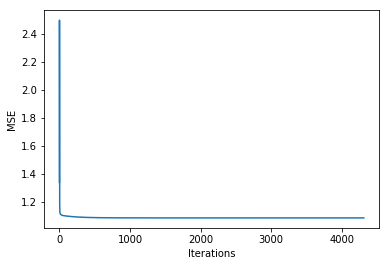

In [154]:
w, MSE_history = gradient_descent_mse_history(X_train, Y_train, w_0, 0.001, 10, 0.0163)
xaxis = list(range(len(MSE_history)))
plt.plot(xaxis, MSE_history[0])
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.show()

**stability - varying hyperparameters**

**Differences in epsilon and their effects on the weights and MSE**

1. A sufficiently low epsilon (tolerance) will give the same weights as the closed form solution

In [121]:
w_gradient_descent_epsilon_1 = gradient_descent(X_train, Y_train, w_0, 0.0001,10, 0.0001)
w_gradient_descent_epsilon_1.T

,0,1,2,3
0,0.375364,-1.085847,-0.226277,0.820925


2. A higher epsilon value will give slightly different weights but won't affect the MSE, as compared to the closed form solution

In [122]:
w_gradient_descent_epsilon_2 = gradient_descent(X_train, Y_train, w_0, 0.0001,10, 0.01)
w_gradient_descent_epsilon_2.T

,0,1,2,3
0,0.375364,-1.085804,-0.226276,0.820925


3. An epsilon value that is too high will also affect the MSE, raising it

In [124]:
w_gradient_descent_epsilon_3 = gradient_descent(X_train, Y_train, w_0, 0.0001,10, 10)
w_gradient_descent_epsilon_3.T

,0,1,2,3
0,0.375251,-1.042665,-0.225981,0.820334


In [21]:
print('Training MSE', MSE(X_train, Y_train, w_gradient_descent))
print('Validation MSE', MSE(X_val, Y_val, w_gradient_descent))

Training MSE 0    1.084705
dtype: float64
Validation MSE 0    1.020521
dtype: float64


summarize these results in a graph

In [125]:
#finding optimal epsilon
mse = 2
epsilon = 20
w_1 = gradient_descent(X_train, Y_train, w_0, 0.0001,10, epsilon)
MSE_history_train = pd.DataFrame(MSE(X_train,Y_train,w_1))
MSE_history_val = pd.DataFrame(MSE(X_val,Y_val,w_1))
while (np.any(mse>1.020327) & (epsilon>0)):
    epsilon = epsilon-(epsilon/6)
    w_gradient_descent = gradient_descent(X_train, Y_train, w_0, 0.0001,10, epsilon)
    mse = MSE(X_val,Y_val,w_gradient_descent)
    MSE_history_train = MSE_history_train.append(pd.DataFrame(MSE(X_train,Y_train,w_gradient_descent)), ignore_index = True)
    MSE_history_val = MSE_history_val.append(pd.DataFrame(MSE(X_val,Y_val,w_gradient_descent)), ignore_index = True)

In [126]:
epsilon_history = pd.DataFrame(np.array([20]))
epsilon = 20
for i in range(0,39):
    epsilon = pd.DataFrame(np.array([epsilon-(epsilon/6)]))
    epsilon_history = epsilon_history.append(epsilon, ignore_index = True)

In [127]:
epsilon_history.T #hence the optimal epsilon is the last one, 0.0163

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,20.0,16.666667,13.888889,11.574074,9.645062,8.037551,6.69796,5.581633,4.651361,3.876134,...,0.084254,0.070212,0.05851,0.048758,0.040632,0.03386,0.028217,0.023514,0.019595,0.016329


<Figure size 288x216 with 0 Axes>

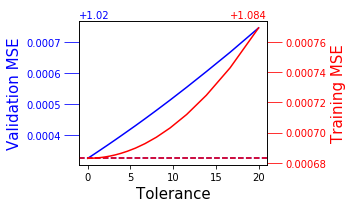

In [128]:
plt.figure(figsize = (4,3))
fig, ax1 = plt.subplots(figsize = (5,3))
ax1.plot(epsilon_history, MSE_history_val, 'b-')
ax1.set_xlabel('Tolerance', size = 15)
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Validation MSE', color='b', size = 15)
ax1.tick_params('y', colors='b', size = 15)
ax1.axhline(y=1.020327, linestyle = '--', color = 'b')

ax2 = ax1.twinx()
ax2.plot(epsilon_history, MSE_history_train, '-r')
ax2.axhline(y=1.084683, linestyle = '--', color = 'r')
ax2.set_ylabel('Training MSE', color='r', size= 15)
ax2.tick_params('y', colors='r', size = 15)

fig.tight_layout()
plt.show()

**Differences in the learning rate**

In [129]:
#really high beta value means that the learning rate decays really fast
#so we want the lowest beta (hence slow decay) that gives a good MSE
w_gradient_descent_rate_1 = gradient_descent(X_train, Y_train, w_0, 0.0001,1000, 0.0163)
print('Training MSE', MSE(X_train, Y_train, w_gradient_descent_rate_1))
print('Validation MSE', MSE(X_val, Y_val, w_gradient_descent_rate_1))
#these are the same MSE values as for closed form

Training MSE 0    1.084683
dtype: float64
Validation MSE 0    1.020327
dtype: float64


In [130]:
w_gradient_descent_rate = gradient_descent(X_train, Y_train, w_0, 0.0001,0.0000000001, 0.0163)
w_gradient_descent_rate.T

,0,1,2,3
0,0.375364,-1.085777,-0.226276,0.820924


so changing beta doesn't affect much except the runtime (at this initial learning rate)

In [131]:
#change the initial learning rate
w_gradient_descent_rate = gradient_descent(X_train, Y_train, w_0, 100000,0.0100, 0.0163)
print('Training MSE', MSE(X_train, Y_train, w_gradient_descent_rate))
print('Validation MSE', MSE(X_val, Y_val, w_gradient_descent_rate))
#these are the same MSE values as for closed form

Training MSE 0    1.084683
dtype: float64
Validation MSE 0    1.020326
dtype: float64


therefore, the way that the decaying learning rate is set up, the rate parameters don't affect the MSE results. If it weren't a decaying rate but a fixed one, what would be the effects?

In [132]:
def gradient_descent_fix_rate(x,y,w,alpha,epsilon):
    grad = epsilon+1 #initializes while loop, will always be greater than epsilon
    #MSE_history = pd.DataFrame(MSE(x,y,w))
    p1 = np.dot(x.T,x)
    p2 = np.dot(x.T, y)
    while abs(grad) > epsilon:
        gradient = 2*(np.dot(p1,w)-p2)
        grad = np.linalg.norm(gradient)
        w = w-alpha*(gradient)
        #MSE_history = MSE_history.append(pd.DataFrame(MSE(x,y,w)), ignore_index = True)
    return w

In [133]:
w_fix_rate = gradient_descent_fix_rate(X_train, Y_train, w_0, 0.00005, 0.0163)
#if the learning rate is too large, we get a warning

C:\Users\user\Anaconda3.2\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in multiply
  import sys


**Runtime** (at optimal parameters)

In [134]:
%%timeit
w_gradient_descent_opt = gradient_descent(X_train, Y_train, w_0, 0.0001,10, 0.0163)

2.12 s ± 46.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Differences in initial weight and runtime**

In [135]:
def gradient_descent_with_iteration_count(x,y,w,n, beta,epsilon):
    grad = epsilon+1 #initializes while loop, will always be greater than epsilon
    #MSE_history = pd.DataFrame(MSE(x,y,w))
    p1 = np.dot(x.T,x)
    p2 = np.dot(x.T, y)
    alpha = n/(1+beta)
    i = 0
    while abs(grad) > epsilon:
        if (alpha>1e-5):
            alpha = n/(1+beta)
            beta = 10*beta #want beta to get bigger with each iteration so that the learning rate decays
        gradient = 2*(np.dot(p1,w)-p2)
        grad = np.linalg.norm(gradient)
        w = w-alpha*(gradient)
        i = i+1
        #MSE_history = MSE_history.append(pd.DataFrame(MSE(x,y,w)), ignore_index = True)
    return w, i

In [136]:
optimal_w = closed_form(X_train, Y_train)
i=1
i_history=pd.DataFrame(np.array([i]))
w_initial = optimal_w*i
w_final, iterations_per_model = gradient_descent_with_iteration_count(X_train, Y_train,w_initial, 0.001, 10, 0.0163)
iterations = pd.DataFrame(np.array([iterations_per_model]))
while(i<500):
    i = 1.3*i
    w_initial = optimal_w*i
    w_final, iterations_per_model = gradient_descent_with_iteration_count(X_train, Y_train,w_initial, 0.001, 10, 0.0163)
    i_history = i_history.append(pd.DataFrame(np.array([i])))
    iterations = iterations.append(pd.DataFrame(np.array([iterations_per_model])))

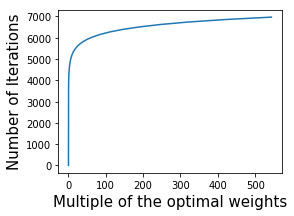

In [137]:
plt.figure(figsize = (4,3))
plt.plot(i_history, iterations)
plt.xlabel("Multiple of the optimal weights", size = 15)
plt.ylabel("Number of Iterations", size = 15)
#plt.title("Effect of weight initialization on the number of iterations required for convergence")
plt.show()

compare runtime of optimal epsilon versus other epsilons, same with beta value?

**Differences in the model when using a subset of the training data**

In [138]:
with open("proj1_data.json") as fp:
    data = json.load(fp)
data = pd.DataFrame.from_dict(data, orient = 'columns')
#Converting true and false values into binaries
data["is_root"] = data["is_root"].astype(int)

#Store Popularity as target variable
y = data["popularity_score"]
#Dropping target variable in data
data = data.drop(['popularity_score', 'text'],1) #get rid of other features and try with just one to begin with

In [139]:
X = np.concatenate((data, singles),axis=1) #add a column of ones for the gradient descent, this is the bias
#Splitting Data
X_train_split_1 = X[:5000]
X_train_split_2 = X[5000:10000]
X_val = X[10000:11000]
#Splitting targets
y = y.values.reshape(12000,1)
Y_train_split_1 = y[:5000]
Y_train_split_2 = y[5000:10000]
Y_val = y[10000:11000]

In [140]:
optimal_w_gradient_descent = gradient_descent(X_train, Y_train, w_0, 0.0001, 10, 0.0163)
optimal_w_closed_form = closed_form(X_train, Y_train)
def percent_difference(a, b):
    diff = 100*np.abs(a-b)/((a+b)/2)
    return diff

In [141]:
w_gradient_descent_split_1 = gradient_descent(X_train_split_1, Y_train_split_1, w_0, 0.0001,10, 0.0163)
print(percent_difference(MSE(X_train_split_1, Y_train_split_1, w_gradient_descent_split_1), 
                   MSE(X_train, Y_train, optimal_w_gradient_descent)))
print(percent_difference(MSE(X_val, Y_val, w_gradient_descent_split_1), 
                   MSE(X_val, Y_val, optimal_w_gradient_descent)))

0    0.221479
dtype: float64
0    0.048928
dtype: float64


In [142]:
#now try with the other half of the split, does using a different training set of the same size give a different error?
w_gradient_descent_split_2 = gradient_descent(X_train_split_2, Y_train_split_2, w_0, 0.0001,10, 0.0163)
print(percent_difference(MSE(X_train_split_2, Y_train_split_2, w_gradient_descent_split_2), 
                   MSE(X_train_split_1, Y_train_split_1, w_gradient_descent_split_1)))
print(percent_difference(MSE(X_val, Y_val, w_gradient_descent_split_2), 
                   MSE(X_val, Y_val, optimal_w_gradient_descent)))

0    0.748786
dtype: float64
0    0.320924
dtype: float64


In [143]:
#is there a minimum subset of the data that will give the same MSE as the training set with 10 000 examples?
#9 is the minimum number of examples in the training set, any lower will give a singular matrix error
X_train_subset = X[:9]
Y_train_subset = y[:9]
w_subset = closed_form(X_train_subset, Y_train_subset)
MSE_train_subset = pd.DataFrame(MSE(X_train_subset, Y_train_subset, w_subset))
MSE_val_subset = pd.DataFrame(MSE(X_val, Y_val, w_subset))
n=0
for i in range(10, 10000):
    X_train_subset = X[:i]
    Y_train_subset = y[:i]
    w_subset = closed_form(X_train_subset, Y_train_subset)
    MSE_train_subset = MSE_train_subset.append(pd.DataFrame(MSE(X_train_subset, Y_train_subset, w_subset)), ignore_index = True)
    MSE_val_subset = MSE_val_subset.append(pd.DataFrame(MSE(X_val, Y_val, w_subset)), ignore_index = True)

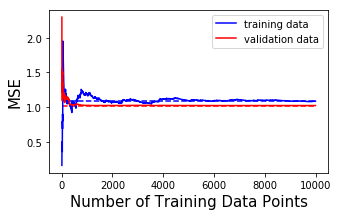

In [144]:
plt.figure(figsize = (5,3))
x_axis = list(range(9, 10000))
plt.plot(x_axis, MSE_train_subset, '-b', label = "training data")
plt.plot(x_axis, MSE_val_subset, '-r', label = "validation data")
plt.xlabel("Number of Training Data Points", size = 15)
plt.ylabel("MSE", size = 15)
plt.hlines(1.084683, 9, 10000, color ='b', linestyle = '--')
plt.hlines(1.020327, 9, 10000, color ='r', linestyle = '--')
plt.legend()
plt.show()